In [68]:
"""
Image processing assignment 4

Group:
  + Abdelrahman Elbehery
  + Yaman Qoudiematy
  + Eslam Mohamed

File : Bag of features image classifier

Notes:
+ All the kernels used are odd an symmetric [3x3, 5x5, ....]
+ Helper functions are added here for readability
+ Some functions have their name changed for readability برضو

Dependencies:
+ numpy
+ opencv [cv2]
+ sklearn
+ matplotlib
"""

import cv2
import pylab
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.externals import joblib
import os

# For readability
read = cv2.imread

# Helper funnctions goes here
def show(img_lst, lbl_lst=None, bin_img=True):
    """
    Attempts to show two images at the same line
    
    ## Arguments
    img_list : the two image objects [np.array] to be shown [left, right]
    lbl_lst  : the text to be shown over each subplot
    """
    num_imgs = len(img_lst)
    if lbl_lst is None: lbl_lst = ['']*num_imgs
    if len(lbl_lst) != num_imgs: raise ValueError('too much/few lables')
    for i, img in enumerate(img_lst):
        pylab.subplot(1, num_imgs, i+1)
        if bin_img: pylab.imshow(img, pylab.cm.gray)
        else : pylab.imshow(img)
        pylab.title(lbl_lst[i])
    pylab.rcParams['figure.figsize'] = (15, 6)
    pylab.show()


### Bag of features classification algorithm steps

+ Start with extracting the key points out of each image in all the classes in order to build up the dictionary of words
+ Quantize this keypoint into a descriptor to obtain the actual rotation and scale invarient vectors of all the useful keypoints
+ Since each image now is represented by an array of vectors; each vector represents some feature, a kmeans clustering for all these features is made. setting `k=500` as mentioned in the assignment
+ once Kmeans algorithms is done, for each training image we will find the centers of its features and build a histogram in order to see which features are repeated more, while doing this we form a data-set such that we know each class is likely to have x set of features by some y amount each

### The code
The algorithm will be written in an object oriented fashion such that a single class encapsulates all of these information and functions and the final interfaces will be through the constructor, `.train()` and `.predict(img)` methods

In [79]:
class BagClassifier(object):
    """
    Bag of words classifier class. Implements clustering using Kmeans
    
    ## Steps of the algorithm for the training phase
    + for each training item it will attempt to get its feature and form the KNN dataset
    + once all the features are collected, get the words or the representative of all of them
    + once all the words are done, for each image in the data-set we will attempt to calculate for which center does
      these descriptor belong
    + a data-set if former where features are number of occurence of each word [feature size = k] and label is its type
    + an SVM is built to further predict future classes
    
    ## Steps of the algorithm for the testing phase
    + get the descriptors of an image
    + use the kmeans to count the frequency of words in it
    + feed this data to the classifier
    
    ## Notes :
    + Descriptors are obtained using the "Oriented FAST and Rotated BRIEF method"
    """
    
    def __init__(self, dataset_dir, k=100, train_ext='.jpg'):
        """
        ## ِ Arguments:
        + dataset_dir : a dictionary with the path for each data-set and the class name of this path. E.g. 
        dataset_dir = {"/dataset/cars_train":"car"} means the directory for the class car is in the key
        + k : the total number of words
        + train_ext : the file extension for the training data items by default it is assumed to be an image
        with in a .jpg format
        """
        self.dataset_dir = dataset_dir
        self.num_features = k
        self.train_extension = train_ext
        self.descriptor_dataset = {class_name:[] for class_name in dataset_dir.values()}
        self.class_labels = {c:i for i,c in enumerate(dataset_dir.values())}
        self.orb = cv2.ORB_create()
        self.kmeans = KMeans(n_clusters=k)
        self.svm = svm.SVC(kernel='linear', C = 1.0)
        self.classifier_dataset = None
        self.dataset_length = 0
        self.normalized = None

    def train(self, samples_per_class = None):
        """
        Trains the classifier
        
        ## arguments
        + samples_per_class : the number of items to consider from the class directory [None for all]
        """        
        for _dir in self.dataset_dir:
            _sample = 0
            _internal_counter = 0
            for filename in os.listdir(_dir):
                if filename.endswith(self.train_extension):
                    img = read(_dir+'/'+filename)
                    key_pts = self.orb.detect(img)
                    descriptor = self.orb.compute(img, key_pts)[1]
                    self.descriptor_dataset[self.dataset_dir[_dir]].append(descriptor)
                    self.dataset_length += 1
                    #_internal_counter += 1*descriptor.shape[0]
                    if samples_per_class is not None and samples_per_class == _sample:
                        break
                    _sample += 1
                    
        # now all the words are collected
        self.kmeans = self.kmeans.fit(np.concatenate(np.concatenate(list(self.descriptor_dataset.values()))))
        # build the data-set with k features +1 for the label number
        self.classifier_dataset = np.zeros([self.dataset_length, self.num_features+1])
        #_c = 0
        _ii = 0
        for cl in self.descriptor_dataset.keys():
            for img_idx, img in enumerate(self.descriptor_dataset[cl]):
                u, c = np.unique(self.kmeans.predict(img), return_counts=True)
                self.classifier_dataset[img_idx+_ii, :-1][u] = c 
            self.classifier_dataset[_ii:_ii+len(self.descriptor_dataset[cl]), -1] = self.class_labels[cl]                    
            _ii += len(self.descriptor_dataset[cl])
        self.normalized = StandardScaler().fit(self.classifier_dataset[:, :-1])
        self.classifier_dataset[:, :-1] = self.normalized.transform(self.classifier_dataset[:, :-1])
        self.svm = self.svm.fit(self.classifier_dataset[:, :-1], self.classifier_dataset[:, -1])
        
    def predict(self, img, verbose=1):
        """
        Inference engine the method return
        
        ## arguments
        + img : np.array of 2D for the image to classify
        + verbose : verbosity level; currently [0 or 1] could be given, if 1 is given only the prediction is printed
        
        ## return
        + detected_class : a string for the actual detected class
        """
        key_pts = self.orb.detect(img)
        descriptor = self.orb.compute(img, key_pts)[1]
        feature_vector = np.zeros([self.num_features])
        #[np.put(feature_vector, u, c) for u,c in [np.unique(r, return_counts=True) for r in self.kmeans.predict(descriptor)]]
        u, c = np.unique(self.kmeans.predict(descriptor), return_counts=True)
        feature_vector[u] = c
        feature_vector = self.normalized.transform(feature_vector.reshape(1,-1))
        #detected_class = self.class_labels[np.ceil(self.svm.predict(feature_vector)).astype(int)]
        if(verbose == 1):
            print(self.svm.predict(feature_vector), self.class_labels)
        return self.svm.predict(feature_vector)

def save_model(obj, file_name):
    """
    exports the model for using later
    
    ## arguments
    + obj : the BagClassifier object
    + file_name : the model dump file name to be loaded later [INCLUDING THE EXTENSION]
    """
    joblib.dump((obj.svm,obj.kmeans, obj.num_features, obj.dataset_dir, obj.normalized), file_name, compress=3)
    
def load_model(model_name):
    """
    creats a model from the dump file containing the model parameters
    
    ## arguments
    + model_name : the dump file name [INCLUDING THE EXTENSION]
    
    ## returns
    + obj : the created BagClassifier object
    """
    
    _svm, _kmeans, _num_features, _dataset_dir, _normalized = joblib.load(model_name)
    obj = BagClassifier(_dataset_dir, _num_features)
    # RIP data hiding
    obj.svm = _svm
    obj.kmeans = _kmeans
    obj.normalized = _normalized
    return obj

### Now the class is built, time to train
+ give the required args via constructor
+ invoke the train
    + note the number of items per class is added as an argument in case the training time consumes alot of time

In [47]:
b = BagClassifier(dataset_dir={"data_set/cars_train":"car",
                              "data_set/faces_train":"face",
                              "data_set/motorbikes_train":"motorbike",
                              "data_set/airplanes_test":"airplane"})


In [48]:
b.train()

### Model inference

Now once the model is trained, time to test it against **few** items from the dataset. Note i am not able to test it on all the dataset since it will consume too much time for $50*4$ images

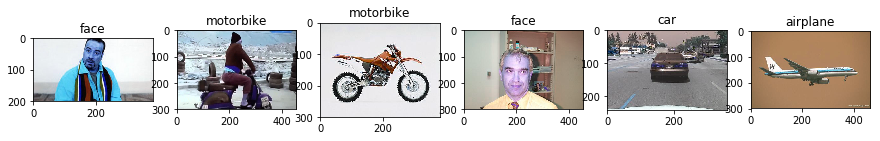

In [93]:
test_images1 = [read("data_set/faces_test/b7ery1.png"),
                read("data_set/motorbikes_test/lmby1.png"),
                read("data_set/motorbikes_test/img004.jpg"),
                read("data_set/faces_test/img021.jpg"),
                read("data_set/cars_test/img011.jpg"),
                read("data_set/airplanes_test/img031.jpg")]

lables = ['car', 'face', 'motorbike', 'airplane']
results = []
for i in test_images1:
    results.append(lables[int(b.predict(i, verbose=False))])
show(test_images1, results, bin_img=False)